In [94]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [95]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
CHANNEL_SIZE = 3
ds = tf.keras.preprocessing.image_dataset_from_directory("image_data/", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE)
                                                         , batch_size=BATCH_SIZE)

Found 2475 files belonging to 2 classes.


In [96]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [97]:
class_names = ds.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [98]:
len(ds)

155

In [99]:
68*32

2176

In [100]:
for image_batch, label_batch in ds.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 128, 128, 3)
[1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0]


In [101]:
for image_batch, label_batch in ds.take(1):
    print(image_batch[0])
    print(label_batch[0].numpy())

tf.Tensor(
[[[168.25 150.25 148.25]
  [163.75 145.75 143.75]
  [168.   150.   148.  ]
  ...
  [161.5  151.5  150.5 ]
  [166.   156.   155.  ]
  [167.75 157.75 156.75]]

 [[173.75 155.75 153.75]
  [170.   152.   150.  ]
  [174.25 156.25 154.25]
  ...
  [170.25 160.25 159.25]
  [163.25 153.25 152.25]
  [171.   161.   160.  ]]

 [[177.   159.   157.  ]
  [177.25 159.25 157.25]
  [180.   162.   160.  ]
  ...
  [165.5  155.5  154.5 ]
  [171.5  161.5  160.5 ]
  [171.   161.   160.  ]]

 ...

 [[173.75 160.75 169.75]
  [160.   147.   156.  ]
  [151.5  138.5  147.5 ]
  ...
  [169.5  163.5  167.5 ]
  [174.5  168.5  172.5 ]
  [187.25 181.25 185.25]]

 [[172.   159.   168.  ]
  [182.75 169.75 178.75]
  [164.75 151.75 160.75]
  ...
  [185.25 179.25 183.25]
  [188.   182.   186.  ]
  [199.5  193.5  197.5 ]]

 [[159.25 146.25 155.25]
  [180.   167.   176.  ]
  [154.   141.   150.  ]
  ...
  [200.5  194.5  198.5 ]
  [189.5  183.5  187.5 ]
  [175.75 169.75 173.75]]], shape=(128, 128, 3), dtype=float32

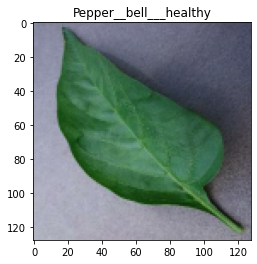

In [102]:
for image_batch, label_batch in ds.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

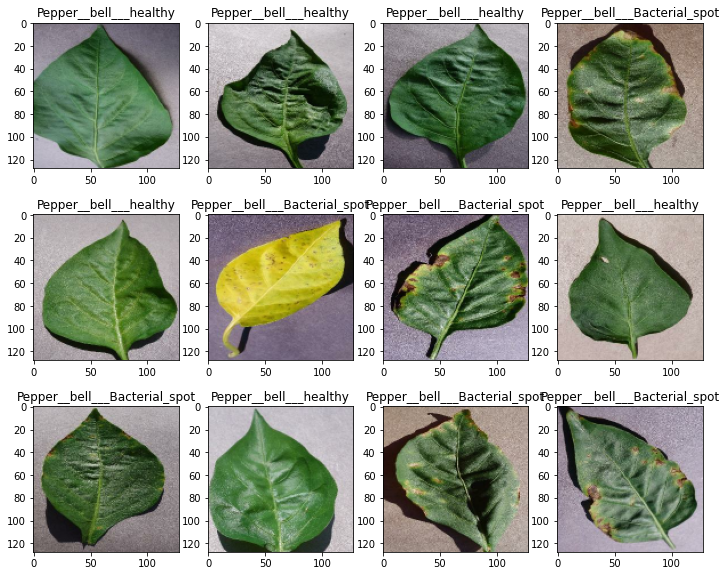

In [103]:
plt.figure(figsize=(12,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [104]:
train_size = 0.8
validation_size = 0.1
test_size = 0.1

In [105]:
train_ds = ds.take(int(len(ds)*train_size))
len(train_ds)

124

In [106]:
valid_plus_test_ds = ds.skip(int(len(ds)*train_size))
len(valid_plus_test_ds)

31

In [107]:
valid_ds = valid_plus_test_ds.take(int(len(ds)*validation_size))
len(valid_ds)

15

In [108]:
test_ds = valid_plus_test_ds.skip(int(len(ds)*validation_size))
len(test_ds)

16

In [109]:
def train_valid_test(dataset, train_size = 0.750, validation_size = 0.125, test_size = 0.125,shuffle=True, shuffle_size=10000):
    ds_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=0)
    train_ds = dataset.take(int(ds_size*train_size))
    valid_plus_test_ds = dataset.skip(int(ds_size*train_size))
    valid_ds = valid_plus_test_ds.take(int(ds_size*validation_size))
    test_ds = valid_plus_test_ds.skip(int(ds_size*validation_size))
    return train_ds, valid_ds, test_ds

In [110]:
train_ds, valid_ds, test_ds = train_valid_test(dataset=ds)

In [111]:
len(train_ds)

116

In [112]:
len(valid_ds)

19

In [113]:
len(test_ds)

20

In [114]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [115]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [116]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2,0.5)
])

In [117]:
tf.keras.backend.clear_session()
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL_SIZE)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPool2D((2,2)), 
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    #layers.Dense(1, activation="sigmoid")#sigmoid is used for binary classification because it's give the probability in YES/NO for each class.
    layers.Dense(2, activation="softmax")
])

In [118]:
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL_SIZE))

In [119]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (16, 128, 128, 3)         0         
                                                                 
 sequential_2 (Sequential)   (16, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 126, 126, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (16, 63, 63, 256)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 61, 61, 128)         295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 30, 30, 128)        0         
 2D)                                                    

In [120]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(train_ds, 
                    epochs=10, 
                    batch_size=BATCH_SIZE,
                    validation_data=valid_ds)

Epoch 1/10
116/116 [==============================] - 15s 103ms/step - loss: 0.6016 - accuracy: 0.6910 - val_loss: 0.5472 - val_accuracy: 0.7368
Epoch 2/10
116/116 [==============================] - 11s 94ms/step - loss: 0.2544 - accuracy: 0.9114 - val_loss: 0.1217 - val_accuracy: 0.9539
Epoch 3/10
116/116 [==============================] - 11s 97ms/step - loss: 0.1733 - accuracy: 0.9444 - val_loss: 0.1133 - val_accuracy: 0.9539
Epoch 4/10
116/116 [==============================] - 11s 97ms/step - loss: 0.1391 - accuracy: 0.9498 - val_loss: 0.0804 - val_accuracy: 0.9704
Epoch 5/10
116/116 [==============================] - 12s 99ms/step - loss: 0.0754 - accuracy: 0.9789 - val_loss: 0.0951 - val_accuracy: 0.9671
Epoch 6/10
116/116 [==============================] - 11s 99ms/step - loss: 0.0903 - accuracy: 0.9708 - val_loss: 0.0353 - val_accuracy: 0.9901
Epoch 7/10
116/116 [==============================] - 13s 110ms/step - loss: 0.0481 - accuracy: 0.9865 - val_loss: 0.0313 - val_accurac

In [62]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 2s 35ms/step - loss: 0.0760 - accuracy: 0.9812


In [63]:
scores

[0.07596398144960403, 0.981249988079071]

In [64]:
history

In [65]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 116}

In [66]:
history.params["epochs"]

10

In [67]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [68]:
history.history["accuracy"]

[0.6569421887397766,
 0.8319827318191528,
 0.8811452984809875,
 0.9216639399528503,
 0.9443544149398804,
 0.9438141584396362,
 0.9643436074256897,
 0.9611021280288696,
 0.9735278487205505,
 0.974608302116394]

In [69]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

EPOCHS = history.params["epochs"]

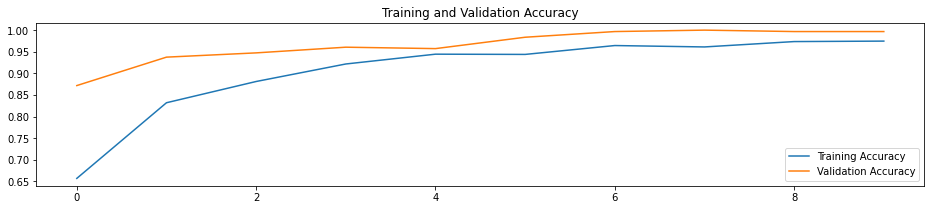

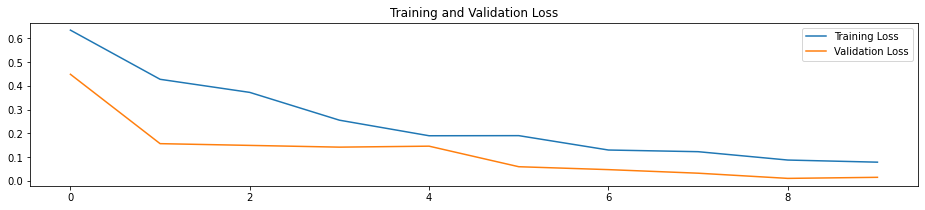

In [70]:
plt.figure(figsize=(35,3))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")
# plt.show()

plt.figure(figsize=(35,3))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

In [83]:
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [92]:
for image_batch, label_batch in test_ds.take(1):
    print(label_batch)

tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(16, 2), dtype=float32)


In [93]:
for image_batch, label_batch in test_ds.take(1):
    print(label_batch[0])
    print(label_batch[0].numpy())
    print(label_batch[0].numpy().shape)

tf.Tensor([0. 1.], shape=(2,), dtype=float32)
[0. 1.]
(2,)


First image to predict----


TypeError: only integer scalar arrays can be converted to a scalar index

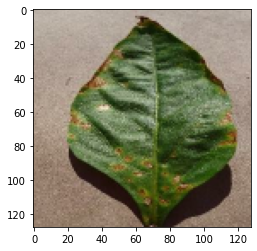

In [71]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0]
    
    print("First image to predict----")
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("\nPredition of Model")
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    print("First image's predicted label:",class_names[np.argmax(batch_prediction[0])])

In [72]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

TypeError: only integer scalar arrays can be converted to a scalar index

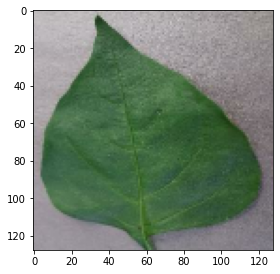

In [73]:
plt.figure(figsize=(18,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off") 

In [74]:
model_version="version_2"
model.save(f"saved_models/{model_version}", save_format="h5")